In [1]:
import math
import os
import random
import zipfile
from importlib import reload
from io import BytesIO

import matplotlib.pyplot as plt
import mglyph as mg
import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as TF
from IPython.display import clear_output, display
from matplotlib import pyplot as plt
from PIL import Image
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.io import ImageReadMode

import mglyph_ml
import mglyph_ml.lib as lib
from mglyph_ml.data.glyph_dataset import GlyphDataset, GlyphSample
from mglyph_ml.glyph_importer import GlyphImporter
from mglyph_ml.manifest_parsing import Manifest
from mglyph_ml.nn.utils import train_one_epoch

reload(mglyph_ml) # TODO: doesn't work

<module 'mglyph_ml' from '/zfs-pool/home/xgaens00/mglyph-ml/src/mglyph_ml/__init__.py'>

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
# here, we simply set up a glyph provider that out GlyphDataset will use to load glyphs from the export
train_glyphs = ["train-square.mglyph", "train-triangle.mglyph", "train-circle.mglyph"]
importers_train = [
    GlyphImporter(f"data/glyphs-experiment-1/{glyph}") for glyph in train_glyphs
]
dataset_train: GlyphDataset = GlyphDataset(*importers_train)

test_glyphs = ["test-square.mglyph", "test-triangle.mglyph", "test-circle.mglyph"]
importers_test = [
    GlyphImporter(f"data/glyphs-experiment-1/{glyph}") for glyph in test_glyphs
]
dataset_test: GlyphDataset = GlyphDataset(
    *importers_test
)  # Changed from importers_train to importers_test

In [4]:
# we create a temporary dataset with normalization turned off so that we can see what exactly is fed into the NN
temp_dataset: GlyphDataset = GlyphDataset(*importers_test, normalize=False, augmentation_seed=69)

In [5]:
# we get a couple of random indices from the dataset so that we can test if the augmentation
# is always the same
random_sample_indices = random.sample(range(len(temp_dataset)), 9)

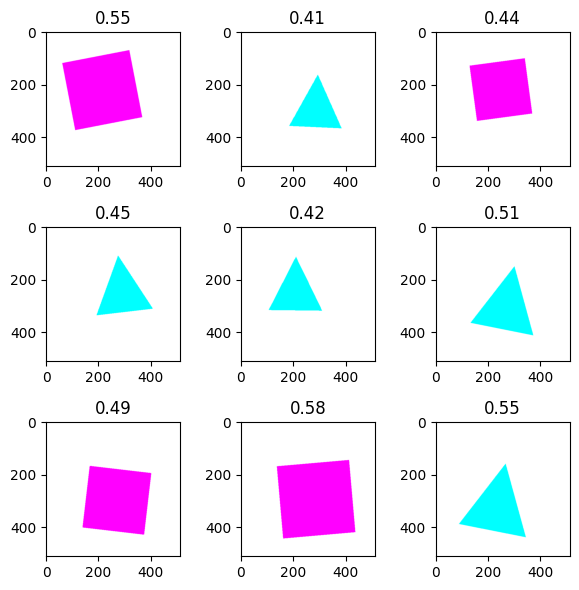

In [ ]:
temp_dataset.reset_transform()  # works!!!
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for index, data in enumerate([temp_dataset[i] for i in random_sample_indices]):
    image, label = data
    # get row and column index for the subplot
    row = index // 3
    col = index % 3

    img = image.numpy().clip(0, 1).transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]

    # display the image
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"{label:.2f}")

plt.tight_layout()
plt.show()

In [ ]:
# quick sanity check before training
# we check that the input data is of the expected shape and properly normalized
print("Sample image shape:", dataset_train[0][0])
print("Sample label:", dataset_train[0][1])

In [ ]:
# next, we create the model
from mglyph_ml.nn.glyph_regressor_gen2 import GlyphRegressor
model = GlyphRegressor()
# we move the model to the GPU for much faster training (if GPU is available)
if device == 'cuda':
    model = model.to(device)

In [ ]:
def evaluate_glyph_regressor(
    model: nn.Module, 
    data_loader: DataLoader, 
    device: str, 
    criterion
) -> float:
    """
    Takes a glyph regressor, temporarily disables gradient calculation, and calculates the average
    loss on the given dataset (DataLoader). Processes in batches on GPU for efficiency.
    """
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.view(-1, 1)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            num_batches += 1
    
    avg_loss = running_loss / num_batches if num_batches > 0 else 0.0
    model.train()  # Set model back to training mode
    return avg_loss

In [ ]:
indices_debug = list(range(0, len(dataset_train), 16))
dataset_debug = Subset(dataset_train, indices_debug)

# simply change the dataset to any other, and train :)
# data_loader_train = DataLoader(dataset_debug, batch_size=16, shuffle=True)
data_loader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)

data_loader_test = DataLoader(dataset_test, batch_size=64)

criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0003, momentum=0.00001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()
losses = []
accuracies = []
test_losses = []
test_accuracies = []

# Train for 5 epochs
for epoch in range(10):
    loss = train_one_epoch(model, data_loader_train, device, criterion, optimizer)
    error = loss * 10_000
    losses.append(loss)
    accuracies.append(error)

    test_loss = evaluate_glyph_regressor(model, data_loader_test)

    # Clear previous plots
    ax1.clear()
    ax2.clear()
    
    # Plot updated data with markers
    ax1.plot(range(len(losses)), losses, color='red', label='Train Loss', marker='o', markersize=4)
    ax2.plot(range(len(accuracies)), accuracies, color='purple', label='Train Accuracy', marker='o', markersize=4)
    ax1.plot(range(len(test_losses)), losses, color='cyan', label='Test Loss', marker='o', markersize=4)
    ax2.plot(range(len(test_accuracies)), accuracies, color='green', label='Test Accuracy', marker='o', markersize=4)
    
    # Set labels and x-axis ticks
    ax1.set_xlabel('Epoch')
    ax1.set_xticks(range(len(losses)))
    fig.legend(loc='upper right')
    
    # Update display
    clear_output(wait=True)
    print(f"E={epoch}; L={loss:.8f}; error={error:.2f}")
    if error < 0.3:
        break
    display(fig)


In [ ]:
# Saving and loading the model!
# torch.save(model, )

In [ ]:
# Evaluate all examples and collect errors
# model = model.to('cpu')
# train_errors = []
# test_errors = []

# with torch.no_grad():
#     # Evaluate training set
#     for i in range(len(dataset_train)):
#         input, label = dataset_train[i]
#         img_batch = input.unsqueeze(0)
#         pred = model(img_batch).item()
#         error = (pred - label) * 100
#         train_errors.append(error)
    
#     # Evaluate test set
#     for i in range(len(dataset_test)):
#         input, label = dataset_test[i]
#         img_batch = input.unsqueeze(0)
#         pred = model(img_batch).item()
#         error = (pred - label) * 100
#         test_errors.append(error)

train_mean = np.mean(train_errors)
train_std = np.std(train_errors)
test_mean = np.mean(test_errors)
test_std = np.std(test_errors)

plt.figure(figsize=(10, 6))
bins = np.linspace(min(min(train_errors), min(test_errors)), 
                   max(max(train_errors), max(test_errors)), 50)

plt.hist(train_errors, bins=bins, alpha=0.5, label=f'Training (μ={train_mean:.2f}, σ={train_std:.2f})', 
         density=True, color='blue')
plt.hist(test_errors, bins=bins, alpha=0.5, label=f'Test (μ={test_mean:.2f}, σ={test_std:.2f})', 
         density=True, color='red')

plt.xlabel('Prediction Error (units of x)')
plt.ylabel('Density')
plt.title('Distribution of Prediction Errors on Training and Test Sets')
plt.legend()
plt.grid(True, alpha=0.3)

print(f"Training Set Statistics:")
print(f"  Mean Error: {train_mean:.2f}%")
print(f"  Std Dev:    {train_std:.2f}%")
print(f"  Min Error:  {min(train_errors):.2f}%")
print(f"  Max Error:  {max(train_errors):.2f}%")
print(f"\nTest Set Statistics:")
print(f"  Mean Error: {test_mean:.2f}%")
print(f"  Std Dev:    {test_std:.2f}%")
print(f"  Min Error:  {min(test_errors):.2f}%")
print(f"  Max Error:  {max(test_errors):.2f}%")

plt.show()

In [ ]:
# here, we can analyze the model a little bit, see what it's doing internally
def visualize_kernels(model: GlyphRegressor, layer_idx: int = 0, ncols: int = 8, figsize=(10,10), cmap="viridis"):
    """
    Visualize convolution kernels from the model's feature extractor.
    - If kernel has 3 input channels, shows as RGB.
    - Otherwise shows averaged (grayscale) kernel per output channel.
    - layer_idx: 0 for first conv, 1 for second conv, 2 for third conv
    """
    # get the conv layer from sequential
    conv_layers = [module for module in model.features if isinstance(module, nn.Conv2d)]
    if layer_idx >= len(conv_layers):
        raise ValueError(f"Layer index {layer_idx} is out of range. Model has {len(conv_layers)} conv layers.")
    
    layer = conv_layers[layer_idx]
    weight = layer.weight.detach().cpu()  # shape: (out_ch, in_ch, kH, kW)
    out_ch, in_ch, _, _ = weight.shape

    nrows = math.ceil(out_ch / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape(-1)

    for i in range(nrows * ncols):
        ax = axes[i]
        ax.axis("off")
        if i >= out_ch:
            continue
        kern = weight[i]  # (in_ch, kH, kW)
        if in_ch == 3:
            # to H,W,C for display; normalize per-filter
            img = kern.permute(1, 2, 0).numpy()
            # normalize to 0..1
            mi, ma = img.min(), img.max()
            if ma - mi > 0:
                img = (img - mi) / (ma - mi)
            ax.imshow(img)
            ax.set_title(f"f{i} (RGB)")
        else:
            # average across input channels -> single plane
            img = kern.mean(dim=0).numpy()
            mi, ma = img.min(), img.max()
            if ma - mi > 0:
                img = (img - mi) / (ma - mi)
            ax.imshow(img, cmap=cmap)
            ax.set_title(f"f{i} (avg)")
    plt.tight_layout()
    return fig

# After training
# Visualize the three convolutional layers
fig1 = visualize_kernels(model, layer_idx=0, ncols=4, figsize=(8,8))  # First conv (16 kernels)
plt.show()
fig2 = visualize_kernels(model, layer_idx=1, ncols=8, figsize=(8,4))  # Second conv (32 kernels)
plt.show()
fig3 = visualize_kernels(model, layer_idx=2, ncols=8, figsize=(8,8))  # Third conv (64 kernels)
plt.show()

In [ ]:
import os
from PIL import Image
import numpy as np

def export_kernels(model: torch.nn.Module, layer_name: str, out_dir: str, cmap: str = "viridis"):
    """
    Export all kernels from a specified convolutional layer to images in `out_dir`.
    - If kernels have 3 input channels, saves as RGB images.
    - Otherwise, saves as grayscale images (averaged over input channels).
    """
    os.makedirs(out_dir, exist_ok=True)
    layer = getattr(model, layer_name, None)
    if layer is None:
        raise ValueError(f"Model has no attribute '{layer_name}'")
    weight = layer.weight.detach().cpu()  # (out_ch, in_ch, kH, kW)
    out_ch, in_ch, kH, kW = weight.shape
    for i in range(out_ch):
        kern = weight[i]  # (in_ch, kH, kW)
        if in_ch == 3:
            # RGB kernel: (3, kH, kW) -> (kH, kW, 3)
            img = kern.permute(1, 2, 0).numpy()
            mi, ma = img.min(), img.max()
            if ma - mi > 0:
                img = (img - mi) / (ma - mi)
            img = (img * 255).astype(np.uint8)
            im = Image.fromarray(img, mode="RGB")
        else:
            # Grayscale: average over input channels
            img = kern.mean(dim=0).numpy()
            mi, ma = img.min(), img.max()
            if ma - mi > 0:
                img = (img - mi) / (ma - mi)
            img = (img * 255).astype(np.uint8)
            im = Image.fromarray(img, mode="L")
        out_path = os.path.join(out_dir, f"{layer_name}_kernel_{i}.png")
        im.save(out_path)
    print(f"Exported {out_ch} kernels from '{layer_name}' to {out_dir}")

export_kernels(model=model, layer_name="conv3", out_dir="data/kernels")